In [1]:
import sys
import pandas as pd
import numpy as np
import sklearn
import keras
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from keras.utils.np_utils import to_categorical



Using TensorFlow backend.


In [2]:
names = ['diagnosis', 'fvc', 'fev1', 'performance_status', 'pain_before_surgery',
        'haemoptysis_before_surgery', 'dyspnoea_before_surgery', 'cough_before_surgery', 'weakness_before_surgery',
        'tumour_size', 'diabetes_mellitus', 'mi_6_months', 'peripheral_arterial_disease', 'smoking', 'asthma', 
         'age', 'survival']

#From https://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data
df = pd.read_csv("/Users/tommykwan/Documents/MachineLearning/DeepLearning/thoracic-surgery-survival/thoracic-surgery-data.csv", names = names)

# Unsure of how to interpret diagnosis, may implement later 
df = df.drop(columns=['diagnosis'])

# # Drop age for this version
# df = df.drop(columns=['age'])


print(df)


      fvc   fev1 performance_status pain_before_surgery  \
0    2.88   2.16               PRZ1                   F   
1    3.40   1.88               PRZ0                   F   
2    2.76   2.08               PRZ1                   F   
3    3.68   3.04               PRZ0                   F   
4    2.44   0.96               PRZ2                   F   
5    2.48   1.88               PRZ1                   F   
6    4.36   3.28               PRZ1                   F   
7    3.19   2.50               PRZ1                   F   
8    3.16   2.64               PRZ2                   F   
9    2.32   2.16               PRZ1                   F   
10   2.56   2.32               PRZ0                   F   
11   4.28   4.44               PRZ1                   F   
12   3.00   2.36               PRZ1                   F   
13   3.98   3.06               PRZ2                   F   
14   1.96   1.40               PRZ1                   F   
15   4.68   4.16               PRZ1                   F 

In [3]:
# Need to preprocess the data 

# Rename survival as class for ease of reading
df.rename(columns = {'survival': 'class'}, inplace = True) 

print(df)

      fvc   fev1 performance_status pain_before_surgery  \
0    2.88   2.16               PRZ1                   F   
1    3.40   1.88               PRZ0                   F   
2    2.76   2.08               PRZ1                   F   
3    3.68   3.04               PRZ0                   F   
4    2.44   0.96               PRZ2                   F   
5    2.48   1.88               PRZ1                   F   
6    4.36   3.28               PRZ1                   F   
7    3.19   2.50               PRZ1                   F   
8    3.16   2.64               PRZ2                   F   
9    2.32   2.16               PRZ1                   F   
10   2.56   2.32               PRZ0                   F   
11   4.28   4.44               PRZ1                   F   
12   3.00   2.36               PRZ1                   F   
13   3.98   3.06               PRZ2                   F   
14   1.96   1.40               PRZ1                   F   
15   4.68   4.16               PRZ1                   F 

In [4]:
df['performance_status'] = pd.get_dummies(df['performance_status'])
df['pain_before_surgery'] = pd.get_dummies(df['pain_before_surgery'])
df['haemoptysis_before_surgery'] = pd.get_dummies(df['haemoptysis_before_surgery'])
df['dyspnoea_before_surgery'] = pd.get_dummies(df['dyspnoea_before_surgery'])
df['cough_before_surgery'] = pd.get_dummies(df['cough_before_surgery'])
df['weakness_before_surgery'] = pd.get_dummies(df['weakness_before_surgery'])
df['tumour_size'] = pd.get_dummies(df['tumour_size'])
df['diabetes_mellitus'] = pd.get_dummies(df['diabetes_mellitus'])
df['mi_6_months'] = pd.get_dummies(df['mi_6_months'])
df['peripheral_arterial_disease'] = pd.get_dummies(df['peripheral_arterial_disease'])
df['smoking'] = pd.get_dummies(df['smoking'])
df['asthma'] = pd.get_dummies(df['asthma'])
df['class'] = pd.get_dummies(df['class'])


fev1_max = df['fev1'].max()
fev1_min = df['fev1'].min()
df['fev1'] = (df['fev1'] - fev1_min)/(fev1_max-fev1_min)

fvc_max = df['fvc'].max()
fvc_min = df['fvc'].min()
df['fvc'] = (df['fvc'] - fvc_min)/(fvc_max-fvc_min)

age_max = df['age'].max()
age_min = df['age'].min()
df['age'] = (df['age'] - age_min)/(age_max-age_min)


In [5]:
print(df)

          fvc      fev1  performance_status  pain_before_surgery  \
0    0.296296  0.014061                   0                    1   
1    0.403292  0.010780                   1                    1   
2    0.271605  0.013124                   0                    1   
3    0.460905  0.024373                   1                    1   
4    0.205761  0.000000                   0                    1   
5    0.213992  0.010780                   0                    1   
6    0.600823  0.027185                   0                    1   
7    0.360082  0.018045                   0                    1   
8    0.353909  0.019686                   0                    1   
9    0.181070  0.014061                   0                    1   
10   0.230453  0.015936                   1                    1   
11   0.584362  0.040778                   0                    1   
12   0.320988  0.016405                   0                    1   
13   0.522634  0.024607                   0     

In [6]:
y = np.array(df['class'])
X = np.array(df.drop(['class'], 1))
seed = 8
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=seed)

Y_train = to_categorical(y_train, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)


In [7]:
print(X_train)
print(X_train.shape)

[[7.24279835e-01 2.95289431e-02 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 3.93939394e-01]
 [1.15226337e-01 4.68713382e-04 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 7.87878788e-01]
 [4.77366255e-01 1.82798219e-02 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 8.18181818e-01]
 ...
 [2.88065844e-01 1.68736817e-02 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 4.24242424e-01]
 [5.02057613e-01 2.29669557e-02 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 6.96969697e-01]
 [3.29218107e-01 1.64049684e-02 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 5.75757576e-01]]
(376, 15)


In [8]:
print(X_test)
print(X_test.shape)

[[0.40329218 0.02460745 0.         ... 0.         1.         0.71212121]
 [0.52674897 0.01921725 0.         ... 0.         1.         0.56060606]
 [0.2962963  0.0140614  0.         ... 0.         1.         0.59090909]
 ...
 [0.16049383 0.00468713 1.         ... 0.         1.         0.63636364]
 [0.54320988 0.02624795 1.         ... 0.         1.         0.51515152]
 [0.46090535 0.02249824 0.         ... 0.         1.         0.56060606]]
(94, 15)


In [9]:
print(y_train)

[1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 0 1]


In [10]:
print(y_test)

[0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [11]:
print(Y_train)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 

In [12]:
print(Y_test)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [13]:
from keras.optimizers import SGD
opt = SGD(lr=0.0003,decay=1e-6, momentum = 0.7, nesterov=True)

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(15, input_dim=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = create_model()

print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 422
Trainable params: 422
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
history = model.fit(X_train, Y_train, epochs=200, batch_size=15, verbose = 1, validation_split = 0.2);

Train on 300 samples, validate on 76 samples
Epoch 1/200
300/300 [==============================] - 0s 1ms/step - loss: 0.6929 - acc: 0.5167 - val_loss: 0.6867 - val_acc: 0.8553
Epoch 2/200
300/300 [==============================] - 0s 60us/step - loss: 0.6812 - acc: 0.8667 - val_loss: 0.6759 - val_acc: 0.8553
Epoch 3/200
300/300 [==============================] - 0s 59us/step - loss: 0.6710 - acc: 0.8667 - val_loss: 0.6675 - val_acc: 0.8553
Epoch 4/200
300/300 [==============================] - 0s 66us/step - loss: 0.6635 - acc: 0.8667 - val_loss: 0.6607 - val_acc: 0.8553
Epoch 5/200
300/300 [==============================] - 0s 62us/step - loss: 0.6566 - acc: 0.8667 - val_loss: 0.6543 - val_acc: 0.8553
Epoch 6/200
300/300 [==============================] - 0s 62us/step - loss: 0.6500 - acc: 0.8667 - val_loss: 0.6480 - val_acc: 0.8553
Epoch 7/200
300/300 [==============================] - 0s 65us/step - loss: 0.6436 - acc: 0.8667 - val_loss: 0.6419 - val_acc: 0.8553
Epoch 8/200
300/30

300/300 [==============================] - 0s 57us/step - loss: 0.4549 - acc: 0.8667 - val_loss: 0.4655 - val_acc: 0.8553
Epoch 62/200
300/300 [==============================] - 0s 63us/step - loss: 0.4532 - acc: 0.8667 - val_loss: 0.4639 - val_acc: 0.8553
Epoch 63/200
300/300 [==============================] - 0s 60us/step - loss: 0.4515 - acc: 0.8667 - val_loss: 0.4624 - val_acc: 0.8553
Epoch 64/200
300/300 [==============================] - 0s 56us/step - loss: 0.4499 - acc: 0.8667 - val_loss: 0.4610 - val_acc: 0.8553
Epoch 65/200
300/300 [==============================] - 0s 57us/step - loss: 0.4483 - acc: 0.8667 - val_loss: 0.4596 - val_acc: 0.8553
Epoch 66/200
300/300 [==============================] - 0s 57us/step - loss: 0.4468 - acc: 0.8667 - val_loss: 0.4582 - val_acc: 0.8553
Epoch 67/200
300/300 [==============================] - 0s 58us/step - loss: 0.4453 - acc: 0.8667 - val_loss: 0.4569 - val_acc: 0.8553
Epoch 68/200
300/300 [==============================] - 0s 58us/step

300/300 [==============================] - 0s 101us/step - loss: 0.4010 - acc: 0.8667 - val_loss: 0.4197 - val_acc: 0.8553
Epoch 122/200
300/300 [==============================] - 0s 107us/step - loss: 0.4006 - acc: 0.8667 - val_loss: 0.4194 - val_acc: 0.8553
Epoch 123/200
300/300 [==============================] - 0s 108us/step - loss: 0.4002 - acc: 0.8667 - val_loss: 0.4192 - val_acc: 0.8553
Epoch 124/200
300/300 [==============================] - 0s 104us/step - loss: 0.3999 - acc: 0.8667 - val_loss: 0.4189 - val_acc: 0.8553
Epoch 125/200
300/300 [==============================] - 0s 91us/step - loss: 0.3995 - acc: 0.8667 - val_loss: 0.4186 - val_acc: 0.8553
Epoch 126/200
300/300 [==============================] - 0s 87us/step - loss: 0.3992 - acc: 0.8667 - val_loss: 0.4184 - val_acc: 0.8553
Epoch 127/200
300/300 [==============================] - 0s 102us/step - loss: 0.3989 - acc: 0.8667 - val_loss: 0.4182 - val_acc: 0.8553
Epoch 128/200
300/300 [==============================] - 

300/300 [==============================] - 0s 86us/step - loss: 0.3902 - acc: 0.8667 - val_loss: 0.4134 - val_acc: 0.8553
Epoch 182/200
300/300 [==============================] - 0s 76us/step - loss: 0.3901 - acc: 0.8667 - val_loss: 0.4134 - val_acc: 0.8553
Epoch 183/200
300/300 [==============================] - 0s 63us/step - loss: 0.3901 - acc: 0.8667 - val_loss: 0.4134 - val_acc: 0.8553
Epoch 184/200
300/300 [==============================] - 0s 65us/step - loss: 0.3900 - acc: 0.8667 - val_loss: 0.4134 - val_acc: 0.8553
Epoch 185/200
300/300 [==============================] - 0s 74us/step - loss: 0.3899 - acc: 0.8667 - val_loss: 0.4134 - val_acc: 0.8553
Epoch 186/200
300/300 [==============================] - 0s 77us/step - loss: 0.3899 - acc: 0.8667 - val_loss: 0.4134 - val_acc: 0.8553
Epoch 187/200
300/300 [==============================] - 0s 66us/step - loss: 0.3898 - acc: 0.8667 - val_loss: 0.4133 - val_acc: 0.8553
Epoch 188/200
300/300 [==============================] - 0s 74

In [15]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

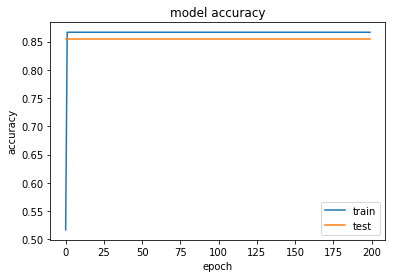

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

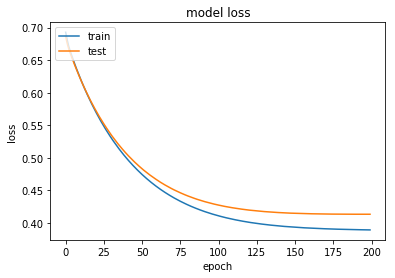

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()